**Implementation of** [DropoutAttack](https://arxiv.org/pdf/2309.01614)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
from os.path import exists, join, basename, splitext
import sys

Mounted at /content/drive


In [46]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torchvision
import torchvision.transforms.functional as F

import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}")

learning_rate = 0.0001
weight_decay = 0.000001
batch_size = 128
num_epochs = 20
num_workers = 2

torch.manual_seed(5)
torch.cuda.manual_seed(5)

Running on cuda


**Import CIFAR-100**

Authors do a 90%/10% split to create training and validation sets

In [3]:
data_loc = "/content"

cifar_mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
cifar_std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

cifar_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=cifar_mean, std=cifar_std)])

dataset = datasets.CIFAR100(root=data_loc, train=True, transform=cifar_transform, download=True)

train_dataset_length = int(.9*len(dataset))
valid_dataset_length = len(dataset) - train_dataset_length

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_dataset_length, valid_dataset_length])
print(f"Dataset sample count: {len(dataset)}")
print(f"Training dataset sample count: {len(train_dataset)} \nValidation dataset sample count: {len(valid_dataset)}")

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,  pin_memory=True, num_workers=num_workers)
valid_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

100%|██████████| 169M/169M [00:20<00:00, 8.30MB/s]


Extracting /content/cifar-100-python.tar.gz to /content
Dataset sample count: 50000
Training dataset sample count: 45000 
Validation dataset sample count: 5000


**Visualize CIFAR-100**

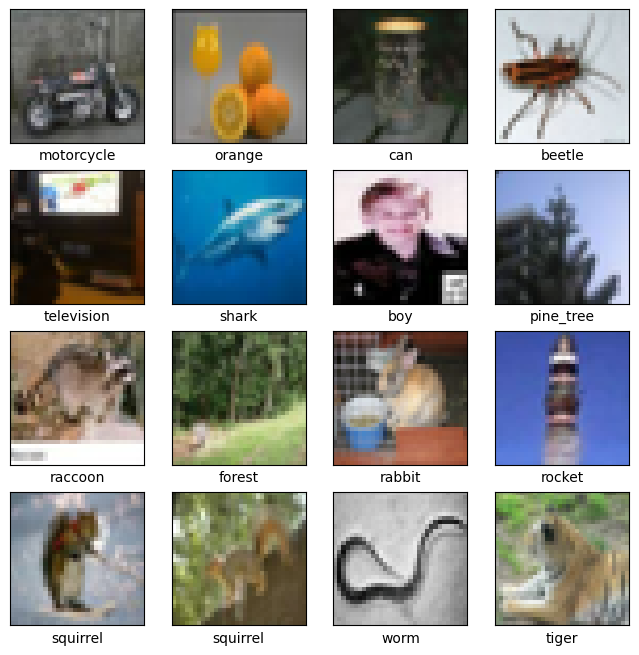

In [11]:
%matplotlib inline
imgs, labels = next(iter(train_dataloader))
mean = torch.tensor([0.5070751592371323, 0.48654887331495095, 0.4409178433670343])
std =  torch.tensor([0.2673342858792401, 0.2564384629170883, 0.27615047132568404])

def plot_imgs(imgs, labels):
  plt.figure(figsize=(8,8))
  for i in range(16):
      plt.subplot(4, 4, i+1)
      img = imgs[i].detach() * std[:, None, None] + mean[:, None, None]
      img = img.numpy().transpose(1,2,0)
      plt.xlabel(class_names[labels[i]])
      plt.xticks([])
      plt.yticks([])
      plt.imshow(img)


  plt.show()

plot_imgs(imgs, labels)

**Train VGG (as specified in paper)**



In [ ]:
class VGGModified(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_block1 = self.getBlock(3,64)
    self.conv_block2 = self.getBlock(64,128)
    self.conv_block3 = self.getBlock(128,256)
    self.conv_block4 = self.getBlock(256,512)
    self.conv_block5 = self.getBlock(512,512)
    self.flatten = nn.Flatten()
    self.linear_stack = nn.Sequential(nn.Dropout(),
                                      nn.Linear(in_features=7*7*512, out_features=4096),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(in_features=4096, out_features=1024),
                                      nn.ReLU(),
                                      nn.Linear(in_features=1024, out_features=100))

  def getBlock(self, in_channels, out_channels):
    return nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1),
                  nn.BatchNorm2d(num_features=out_channels),
                  nn.ReLU(),
                  nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1),
                  nn.BatchNorm2d(num_features=out_channels),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=1))

  def forward(self, x):
    x = self.conv_block5(self.conv_block4(self.conv_block3(self.conv_block2(self.conv_block1(x)))))
    x = self.flatten(x)
    x = self.linear_stack(x)
    return x


def train(dataloader, model, criterion, optim, device):
  model.train()
  train_loss = 0.0
  correct = 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    output = model(X)
    loss = criterion(output, y)
    train_loss += loss.item()
    correct += (output.argmax(1) == y).type(torch.float).sum().item()
    loss.backward()
    optim.step()
    optim.zero_grad()
  return (correct*100/len(dataloader.dataset)), train_loss/len(dataloader)

def test(dataloader, model, criterion, device):
  model.eval()
  test_loss = 0.0
  correct = 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      output = model(X)
      loss = criterion(output, y)
      test_loss += loss.item()
      correct += (output.argmax(1) == y).type(torch.float).sum().item()

  return (correct*100/len(dataloader.dataset)), test_loss/len(dataloader)

criterion = nn.CrossEntropyLoss()
model = VGGModified()
file_path = '/content/drive/MyDrive/model.pth'
optim = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
model = model.to(device)
if os.path.exists(file_path) and os.path.isfile(file_path):
  print(f"Model found at location {file_path}")
  model.load_state_dict(torch.load(file_path, weights_only=True))
else:
  for i in range(num_epochs):
    train_accuracy, train_loss = train(train_dataloader, model, criterion, optim, device)
    valid_accuracy, valid_loss = test(valid_dataloader, model, criterion, device)
    print(f"Epoch: {i}")
    print(f"Train accuracy: {train_accuracy} Train loss: {train_loss}")
    print(f"Validation accuracy: {valid_accuracy} Validation loss: {valid_loss}")

  torch.save(model.state_dict(), file_path)
  print(f"Saving model at location {file_path}")




**Visualize results**

Predictions


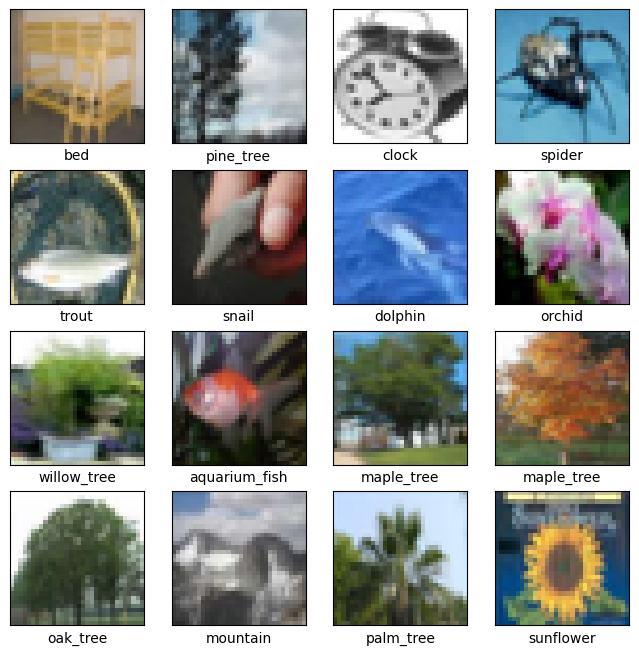

In [32]:
# In the paper the baseline accuracy for VGG16 is reported to be around 60.9%.
imgs, true_labels = next(iter(valid_dataloader))
model.eval()
with torch.inference_mode():
  imgs = imgs.to(device)
  pred = model(imgs)
  class_ids = pred.argmax(1).type(true_labels.dtype)
  imgs, class_ids = imgs.to('cpu'), class_ids.to('cpu')
  print(f"Predictions")
  plot_imgs(imgs, class_ids)






**Min activation attack**

In [42]:
class DropoutCustom(nn.Module):
  def __init__(self, probability=0.5):
    super().__init__()
    if probability > 1.0:
      probability = 1.0
    if probability < 0.0:
      probability = 0.0

    self.p = probability

  def forward(self, X):
    if self.p == 1.0:
      return torch.zeros_like(X)
    if self.p == 0.0:
      return X
    M,N = X.shape
    mask = torch.zeros((M,N)).to(device)
    for i in range(M):
      value, index = torch.kthvalue(X[i,:], int(self.p * N))
      mask[i,:] = X[i,:] < value
    return mask*X


class VGGModifiedMinAttack(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_block1 = self.getBlock(3,64)
    self.conv_block2 = self.getBlock(64,128)
    self.conv_block3 = self.getBlock(128,256)
    self.conv_block4 = self.getBlock(256,512)
    self.conv_block5 = self.getBlock(512,512)
    self.flatten = nn.Flatten()
    self.linear_stack = nn.Sequential(DropoutCustom(),
                                      nn.Linear(in_features=7*7*512, out_features=4096),
                                      nn.ReLU(),
                                      DropoutCustom(),
                                      nn.Linear(in_features=4096, out_features=1024),
                                      nn.ReLU(),
                                      nn.Linear(in_features=1024, out_features=100))

  def getBlock(self, in_channels, out_channels):
    return nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1),
                  nn.BatchNorm2d(num_features=out_channels),
                  nn.ReLU(),
                  nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1),
                  nn.BatchNorm2d(num_features=out_channels),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=1))

  def forward(self, x):
    x = self.conv_block5(self.conv_block4(self.conv_block3(self.conv_block2(self.conv_block1(x)))))
    x = self.flatten(x)
    x = self.linear_stack(x)
    return x


modelMinAttack = VGGModifiedMinAttack()
optimMinAttack = torch.optim.Adam(params=modelMinAttack.parameters(), lr=learning_rate, weight_decay=weight_decay)
modelMinAttack = modelMinAttack.to(device)

for i in range(num_epochs):
  train_accuracy, train_loss = train(train_dataloader, modelMinAttack, criterion, optimMinAttack, device)
  valid_accuracy, valid_loss = test(valid_dataloader, modelMinAttack, criterion, device)
  print(f"Epoch: {i}")
  print(f"Train accuracy: {train_accuracy} Train loss: {train_loss}")
  print(f"Validation accuracy: {valid_accuracy} Validation loss: {valid_loss}")



Epoch: 0
Train accuracy: 0.9533333333333334 Train loss: 4.605521813035011
Validation accuracy: 1.0177777777777777 Validation loss: 4.605230363932523
Epoch: 1
Train accuracy: 0.9555555555555556 Train loss: 4.605410086837682
Validation accuracy: 1.0177777777777777 Validation loss: 4.6051669337532735
Epoch: 2
Train accuracy: 0.9577777777777777 Train loss: 4.605353927070444
Validation accuracy: 1.0333333333333334 Validation loss: 4.605131215669892
Epoch: 3
Train accuracy: 0.9266666666666666 Train loss: 4.605326607823372
Validation accuracy: 1.0333333333333334 Validation loss: 4.605109902945432
Epoch: 4
Train accuracy: 0.9577777777777777 Train loss: 4.605293708768758
Validation accuracy: 1.0333333333333334 Validation loss: 4.605096536603841
Epoch: 5
Train accuracy: 1.0333333333333334 Train loss: 4.605275945229963
Validation accuracy: 1.0333333333333334 Validation loss: 4.605081394314766
Epoch: 6
Train accuracy: 1.0333333333333334 Train loss: 4.60527361116626
Validation accuracy: 1.033333333

**Attacked CNN results**

Predictions


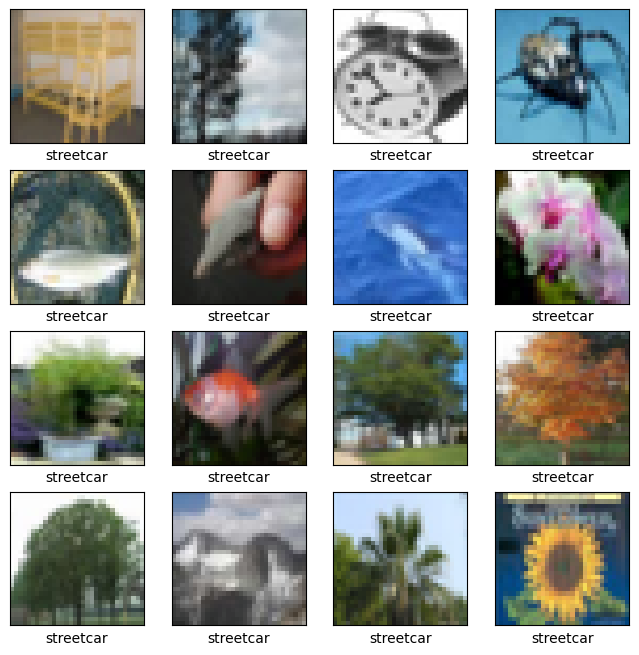

In [49]:
imgs, true_labels = next(iter(valid_dataloader))
modelMinAttack.eval()
with torch.inference_mode():
  imgs = imgs.to(device)
  pred = modelMinAttack(imgs)
  class_ids = pred.argmax(1).type(true_labels.dtype)
  imgs, class_ids = imgs.to('cpu'), class_ids.to('cpu')
  print(f"Predictions")
  plot_imgs(imgs, class_ids)

# Predictions all seem to be streetcar! Need to investigate

**Neuron separation attack**

**Attacked CNN results**